In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
import csv
time_step = []
temps = []

with open('AAPL.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) # Continue execution until the next line in the current function is reached or it returns. 
                 # (The difference between next and step is that step stops inside a called function, 
                 # while next executes called functions at (nearly) full speed, 
                 # only stopping at the next line in the current function.)
    step=0
    for row in reader:
        temps.append(float(row[2]))
        time_step.append(step)
        step = step + 1

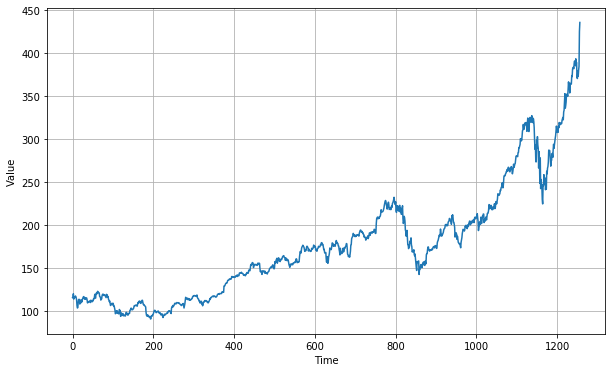

In [4]:
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
series.shape

(1257,)

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30 
batch_size = 32
shuffle_buffer_size = 1257

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1000,)
Epoch 1/100
4/4 [==============================] - 1s 308ms/step - loss: 127.9988 - mae: 128.4988
Epoch 2/100
4/4 [==============================] - 1s 235ms/step - loss: 127.4842 - mae: 127.9842
Epoch 3/100
4/4 [==============================] - 1s 220ms/step - loss: 126.5481 - mae: 127.0481
Epoch 4/100
4/4 [==============================] - 1s 216ms/step - loss: 125.2647 - mae: 125.7647
Epoch 5/100
4/4 [==============================] - 1s 213ms/step - loss: 123.6745 - mae: 124.1745
Epoch 6/100
4/4 [==============================] - 1s 262ms/step - loss: 121.7967 - mae: 122.2967
Epoch 7/100
4/4 [==============================] - 1s 295ms/step - loss: 119.6321 - mae: 120.1321
Epoch 8/100
4/4 [==============================] - 1s 274ms/step - loss: 117.1713 - mae: 117.6713
Epoch 9/100
4/4 [==============================] - 1s 276ms/step - loss: 114.3956 - mae: 114.8956
Epoch 10/100
4/4

4/4 [==============================] - 1s 192ms/step - loss: 36.6903 - mae: 37.1884
Epoch 85/100
4/4 [==============================] - 1s 210ms/step - loss: 34.2161 - mae: 34.7141
Epoch 86/100
4/4 [==============================] - 1s 197ms/step - loss: 33.2137 - mae: 33.7112
Epoch 87/100
4/4 [==============================] - 1s 198ms/step - loss: 31.9046 - mae: 32.4013
Epoch 88/100
4/4 [==============================] - 1s 205ms/step - loss: 32.1734 - mae: 32.6712
Epoch 89/100
4/4 [==============================] - 1s 188ms/step - loss: 31.8393 - mae: 32.3358
Epoch 90/100
4/4 [==============================] - 1s 215ms/step - loss: 31.9018 - mae: 32.3981
Epoch 91/100
4/4 [==============================] - 1s 211ms/step - loss: 33.3172 - mae: 33.8149
Epoch 92/100
4/4 [==============================] - 1s 210ms/step - loss: 34.2913 - mae: 34.7883
Epoch 93/100
4/4 [==============================] - 1s 218ms/step - loss: 34.9677 - mae: 35.4661
Epoch 94/100
4/4 [=========================

[1e-08, 0.0001, 0, 60]

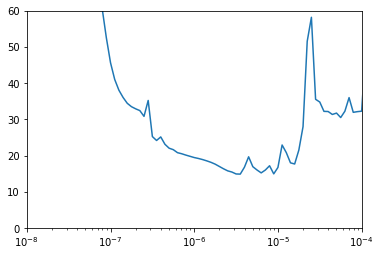

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
10/10 [==============================] - 1s 133ms/step - loss: 60.1497 - mae: 60.6479
Epoch 2/500
10/10 [==============================] - 1s 117ms/step - loss: 28.7081 - mae: 29.2051
Epoch 3/500
10/10 [==============================] - 1s 122ms/step - loss: 20.3586 - mae: 20.8526
Epoch 4/500
10/10 [==============================] - 1s 114ms/step - loss: 29.3454 - mae: 29.8422
Epoch 5/500
10/10 [==============================] - 1s 125ms/step - loss: 27.4051 - mae: 27.9020
Epoch 6/500
10/10 [==============================] - 1s 115ms/step - loss: 26.2987 - mae: 26.7953
Epoch 7/500
10/10 [==============================] - 1s 118ms/step - loss: 28.1848 - mae: 28.6819
Epoch 8/500
10/10 [==============================] - 1s 115ms/step - loss: 26.3598 - mae: 26.8570
Epoch 9/500
10/10 [==============================] - 1s 122ms/step - loss: 24.5874 - mae: 25.0836
Epoch 10/500
10/10 [==============================] - 1s 116ms/step - loss: 25.3505 - mae: 25.8454
Epoch 11/500
10/10 

10/10 [==============================] - 1s 121ms/step - loss: 9.1277 - mae: 9.6153
Epoch 85/500
10/10 [==============================] - 1s 119ms/step - loss: 8.3219 - mae: 8.8079
Epoch 86/500
10/10 [==============================] - 1s 119ms/step - loss: 7.7295 - mae: 8.2145
Epoch 87/500
10/10 [==============================] - 1s 120ms/step - loss: 7.0532 - mae: 7.5362
Epoch 88/500
10/10 [==============================] - 1s 115ms/step - loss: 7.6022 - mae: 8.0873
Epoch 89/500
10/10 [==============================] - 1s 119ms/step - loss: 6.9803 - mae: 7.4647
Epoch 90/500
10/10 [==============================] - 1s 121ms/step - loss: 7.8487 - mae: 8.3344
Epoch 91/500
10/10 [==============================] - 1s 114ms/step - loss: 7.8629 - mae: 8.3485
Epoch 92/500
10/10 [==============================] - 1s 119ms/step - loss: 7.2148 - mae: 7.6991
Epoch 93/500
10/10 [==============================] - 1s 119ms/step - loss: 6.8718 - mae: 7.3554
Epoch 94/500
10/10 [=======================

10/10 [==============================] - 1s 122ms/step - loss: 6.1310 - mae: 6.6145
Epoch 168/500
10/10 [==============================] - 1s 116ms/step - loss: 6.3301 - mae: 6.8138
Epoch 169/500
10/10 [==============================] - 1s 122ms/step - loss: 5.9415 - mae: 6.4241
Epoch 170/500
10/10 [==============================] - 1s 114ms/step - loss: 6.5218 - mae: 7.0054
Epoch 171/500
10/10 [==============================] - 1s 120ms/step - loss: 5.7585 - mae: 6.2416
Epoch 172/500
10/10 [==============================] - 1s 117ms/step - loss: 5.6216 - mae: 6.1035
Epoch 173/500
10/10 [==============================] - 1s 118ms/step - loss: 5.8922 - mae: 6.3737
Epoch 174/500
10/10 [==============================] - 1s 115ms/step - loss: 5.4089 - mae: 5.8899
Epoch 175/500
10/10 [==============================] - 1s 123ms/step - loss: 5.4952 - mae: 5.9767
Epoch 176/500
10/10 [==============================] - 1s 115ms/step - loss: 5.4444 - mae: 5.9236
Epoch 177/500
10/10 [=============

10/10 [==============================] - 1s 121ms/step - loss: 3.7981 - mae: 4.2752
Epoch 251/500
10/10 [==============================] - 1s 112ms/step - loss: 3.6064 - mae: 4.0821
Epoch 252/500
10/10 [==============================] - 1s 118ms/step - loss: 3.5144 - mae: 3.9861
Epoch 253/500
10/10 [==============================] - 1s 113ms/step - loss: 4.8394 - mae: 5.3194
Epoch 254/500
10/10 [==============================] - 1s 118ms/step - loss: 7.3177 - mae: 7.8061
Epoch 255/500
10/10 [==============================] - 1s 114ms/step - loss: 7.0476 - mae: 7.5375
Epoch 256/500
10/10 [==============================] - 2s 163ms/step - loss: 4.6218 - mae: 5.1005
Epoch 257/500
10/10 [==============================] - 1s 127ms/step - loss: 3.8240 - mae: 4.2993
Epoch 258/500
10/10 [==============================] - 1s 135ms/step - loss: 3.6113 - mae: 4.0829
Epoch 259/500
10/10 [==============================] - 1s 119ms/step - loss: 3.7430 - mae: 4.2149
Epoch 260/500
10/10 [=============

10/10 [==============================] - 1s 113ms/step - loss: 3.3578 - mae: 3.8297
Epoch 333/500
10/10 [==============================] - 1s 115ms/step - loss: 3.2159 - mae: 3.6876
Epoch 334/500
10/10 [==============================] - 1s 113ms/step - loss: 2.9715 - mae: 3.4403
Epoch 335/500
10/10 [==============================] - 1s 119ms/step - loss: 3.1142 - mae: 3.5839
Epoch 336/500
10/10 [==============================] - 1s 117ms/step - loss: 3.1546 - mae: 3.6276
Epoch 337/500
10/10 [==============================] - 1s 115ms/step - loss: 3.0471 - mae: 3.5167
Epoch 338/500
10/10 [==============================] - 1s 121ms/step - loss: 2.6594 - mae: 3.1202
Epoch 339/500
10/10 [==============================] - 1s 120ms/step - loss: 3.1330 - mae: 3.6031
Epoch 340/500
10/10 [==============================] - 1s 117ms/step - loss: 3.0634 - mae: 3.5354
Epoch 341/500
10/10 [==============================] - 1s 120ms/step - loss: 2.9604 - mae: 3.4303
Epoch 342/500
10/10 [=============

10/10 [==============================] - 1s 120ms/step - loss: 2.6358 - mae: 3.0991
Epoch 416/500
10/10 [==============================] - 1s 115ms/step - loss: 2.4827 - mae: 2.9415
Epoch 417/500
10/10 [==============================] - 1s 123ms/step - loss: 2.9015 - mae: 3.3728
Epoch 418/500
10/10 [==============================] - 1s 119ms/step - loss: 2.6982 - mae: 3.1632
Epoch 419/500
10/10 [==============================] - 1s 117ms/step - loss: 2.8696 - mae: 3.3365
Epoch 420/500
10/10 [==============================] - 1s 116ms/step - loss: 2.9670 - mae: 3.4352
Epoch 421/500
10/10 [==============================] - 1s 125ms/step - loss: 2.9769 - mae: 3.4433
Epoch 422/500
10/10 [==============================] - 1s 121ms/step - loss: 3.2336 - mae: 3.7044
Epoch 423/500
10/10 [==============================] - 1s 124ms/step - loss: 2.9642 - mae: 3.4337
Epoch 424/500
10/10 [==============================] - 1s 118ms/step - loss: 2.7451 - mae: 3.2123
Epoch 425/500
10/10 [=============

10/10 [==============================] - 1s 149ms/step - loss: 3.4533 - mae: 3.9278
Epoch 499/500
10/10 [==============================] - 2s 162ms/step - loss: 3.4124 - mae: 3.8826
Epoch 500/500
10/10 [==============================] - 1s 142ms/step - loss: 3.1485 - mae: 3.6148


In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

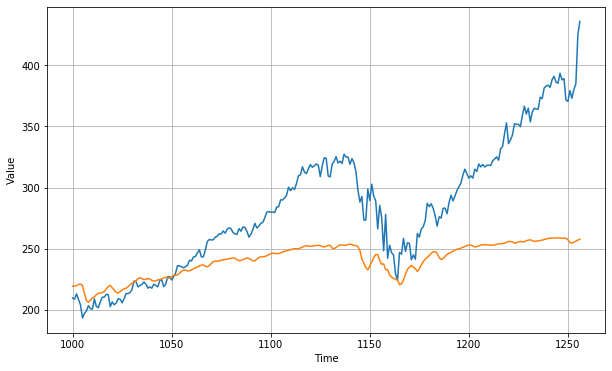

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

44.45209

<Figure size 432x288 with 0 Axes>

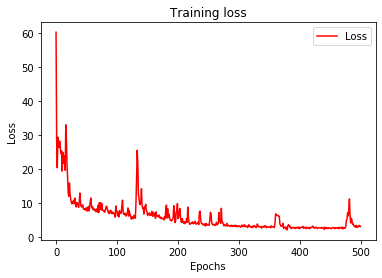

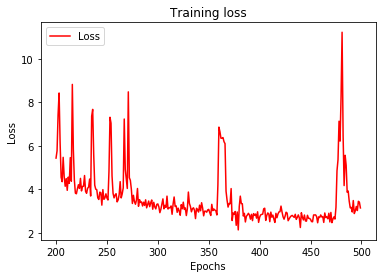

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[219.26082 219.37314 219.76585 220.78577 221.14487 219.77396 213.61906
 207.53708 206.24742 207.8418  209.86693 210.53412 212.40625 213.53201
 213.75037 214.09505 215.01341 217.12938 218.9454  220.0163  218.13364
 216.12596 214.28189 213.82854 214.93044 216.10518 217.0929  217.66183
 218.79611 220.38197 221.71927 222.51895 223.75742 225.43124 226.1336
 225.55283 224.73865 224.9819  225.58987 225.14877 224.17741 223.34738
 223.71025 224.4646  224.73436 225.33714 226.24597 226.56937 225.92464
 225.91357 227.09146 228.1323  228.2681  228.5667  229.96965 231.54517
 232.43756 232.41678 231.76913 231.90804 232.68309 233.59328 234.3803
 235.09692 235.73866 236.5623  236.6584  235.68976 235.17723 236.01346
 237.9119  239.29172 239.82637 239.72263 239.96527 240.63434 240.84349
 241.16345 241.49442 241.74123 242.13571 242.43604 242.16856 240.94798
 240.23466 240.34941 241.05014 241.80966 242.31575 242.04721 241.0834
 239.9632  240.10095 241.43434 242.7124  243.28804 243.41617 243.54167
 244.2484